<h1> Data Analysis for REYeker</h1>

In [2]:
# lib for dataframes
import pandas as pd

# lib for saving np images
from PIL import Image

# lib for plotting
import matplotlib.pyplot as plt

# lib for numerical computations
import numpy as np

# lib for regex
import re

# lib for crerating paths
from pathlib import Path

# REYeker lib
import modules.rEYEkerAnalysis as rEYEker

# for t testing
from scipy import stats

# lib for better plotting
import seaborn as sns
sns.set_theme('paper')

# lib for differ calculation
import difflib

<h2>1. Configuration</h2>

<h5>Database configuration </h5>

In [3]:
# path to the datafile
config_datasheet_path = r'./data/Book4.xlsx'

# columns with visual stimulus data
config_visual_stimulus_variable_array = ['TR20_01', 'TI20_01', 'BR20_01', 'BI20_01']

# columns with names of the algo
config_algo_names = ['TR_FIB', 'TI_FIB', 'BR_FIB', 'BI_FIB']

# columns with time data of visual stimulus
config_time_variable_array = []

# columns with the given answers of the studen
config_answer_variable_array = ['TR10_01', 'TI10_01', 'BR10_01', 'BI10_01']

# regex pattern for correct answer
config_answer_pattern_array = ['2', '2','2','2']

# colums of response time
config_response_time_variable_array = ['TIME042', 'TIME008', 'TIME059', 'TIME023']

<h5>Configuration for REYEker data </h5>

In [4]:
# file for loading rEYEker settings
config_reyeker_settings_path = "data/example.json"

<h5>Configuration for saving images </h5>

In [5]:
# data for loading the images
config_image_path_array = ['images/TR/TR_Fibonacci.png',
               'images/TI/TI_Fibonacci.png',
               'images/BR/BR_Fibonacci.png',
               'images/BI/BI_Fibonacci.png']

# where to save to heatmaps and sequence diagrams
config_folder_prefix_array = [
    'TR/',
    'TI/',
    'BR/',
    'BI/']

# used for saving the heatmaps and sequence diagrams
config_image_prefix_array = [
    'TR_Fibonacci_',
    'TI_Fibonacci_',
    'BR_Fibonacci_',
    'BI_Fibonacci_']

<h5>Configuration for Code Flow data import</h5>

In [6]:
# excel data in data/code_flow
config_code_flow_datasheet_array = ['TR_Fibonacci.xlsx',
                  'TI_Fibonacci.xlsx',
                  'BR_Fibonacci.xlsx',
                  'BI_Fibonacci.xlsx']  

<h5>Configuration for alpha value for t-test </h5>

In [7]:
# confidence needed for t test
config_alpha = 0.05

<h5>Import the columns and create dataframe</h5>

In [8]:
needed_columns_array = []

# create all dataframe headers
for i in range(len(config_visual_stimulus_variable_array)):
    tmp_list = []
    tmp_list.append(config_visual_stimulus_variable_array[i])
    
    if len(config_time_variable_array) != 0:
        tmp_list.append(config_time_variable_array[i])

    tmp_list.append(config_answer_variable_array[i])
    tmp_list.append(config_response_time_variable_array[i])
    needed_columns_array.append(tmp_list)

df_array = []
raw = pd.read_excel(config_datasheet_path)

# read all dataframes
for data_set in needed_columns_array:
    dataframe = pd.DataFrame(raw, columns = data_set)
    dataframe = dataframe.iloc[1:]
    dataframe = dataframe.dropna()
    df_array.append(dataframe)

<h4>Splitting Dataframes in right and wrong answers.</h4>

In [9]:
df_array_right = []
df_array_wrong = []

# iter over every dataframe
for idx, dataframe in enumerate(df_array):
    right_answer_pattern = config_answer_pattern_array[idx]
    regex = re.compile(right_answer_pattern)
    answer_field = config_answer_variable_array[idx]
    
    dataframe_right = pd.DataFrame(columns = needed_columns_array[idx])
    dataframe_wrong = pd.DataFrame(columns = needed_columns_array[idx])
    
    # iter over every row and check if the result is rightr
    for _idx, row  in dataframe.iterrows():
        result = regex.match(str(row[answer_field]))
        if result is not None:
            dataframe_right = dataframe_right.append(row)
        else:
            dataframe_wrong = dataframe_wrong.append(row)
    
    
    
    df_array_right.append(dataframe_right)
    df_array_wrong.append(dataframe_wrong)

<h4>Remove Outliers</h4>

In [10]:
tmp_df_array = []
tmp_df_array_wrong = []

#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(df_array_right):

    data = dataframe[config_response_time_variable_array[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    tmp_df_array.append(cleared_dataframe)
    
#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(df_array_wrong):
    data = dataframe[config_response_time_variable_array[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    tmp_df_array_wrong.append(cleared_dataframe)
    
df_array = tmp_df_array
df_array_wong = tmp_df_array_wrong

<h4>Import REYeker Settings</h4>

In [11]:
(_data, _times, click_setting) = rEYEker.load_data_from_json(config_reyeker_settings_path)

<h4>Import Images Settings</h4>

In [12]:
image_array = []

# read in every image
for image_path in config_image_path_array:
    img = rEYEker.load_image(image_path)
    image_array.append(img)

<h4> Cast Data to Valid format</h4>

Import the visual stimulus measured Data

In [13]:
visual_stimulus_data_matrix = []

#iter over every dataframe
for idx, dataframe in enumerate(df_array):
    visual_stimulus_array = []
    visual_stimulus_row = config_visual_stimulus_variable_array[idx]

    #iter over every row 
    for _idx, item in dataframe.iterrows():
        data_str = item[visual_stimulus_row]
        data_str = data_str.strip()
        coordinates_str = data_str.split(" ")
        coordinates = []
        
        # iter over every coordinate pair x-y
        for coordinate_str in coordinates_str:
            coordinate = coordinate_str.split("-")
            coordinate = (int(coordinate[0]), int(coordinate[1]))
            coordinates.append(coordinate)
            
        visual_stimulus_array.append(coordinates)
        
    visual_stimulus_data_matrix.append(visual_stimulus_array)

Import the Time Data

In [14]:
timestamps_data_matrix = []

#iter over every dataframe
for idx, dataframe in enumerate(df_array):
    if len(config_time_variable_array) <= idx:
        break
    time_measurements = []
    time_measurement_row = config_time_variable_array[idx]

    #iter over every row 
    for _idx, item in dataframe.iterrows():
        data_str = item[time_measurement_row]
        data_str = data_str.strip()
        timestamps = data_str.split(" ")
        timestamps = [int(timestamp) for timestamp in timestamps]
        time_measurement_row.append(timestamps)
        
    timestamps_data_matrix.append(visual_stimulus_measurements)

<h4>Helper Functions</h4>

In [15]:
def save_images(image_array, folder, image_name):
    """
    :brief saves an array of images to a certain location incrementing the postfix by a number
    :param image_array:        array of images (np.ndarray)
    :param folder:     prefix of image/ folder location
    :param image_name: prefix for the image
    """
    
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    prefix = folder + image_name
    
    #TODO create folders if there are none present
    for idx, data in enumerate(image_array):
        data = data*255
        data = np.uint8(data)
        im = Image.fromarray(data)
        im.save(prefix + str(idx) + '.png')
        
def compare_for_h0(arr_1, arr_2, alpha):
    t, p = stats.ttest_ind(arr_1, arr_2)
    if p > alpha:
        return True, t, p
    else:
        return False, t, p
    
def is_in(value, tup):
    return tup[0] <= value <= tup[1]

def get_0_offset(number):
    i = 0
    number = int(number)
    while number != 0:
        number = int(number / 10)
        i = i + 1
    return i

<h2>2. Create Single Heatmaps</h2>

create heatmaps

In [16]:
heatmaps_matrix = []

# iterate over all the datasets
for dataset_idx, stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    time_stamp_array = None
    if len(timestamps_data_matrix) > dataset_idx:
        time_stamp_array = timestamps_data_matrix[dataset_idx]
    
    heatmap_array = []

    # iterate over all the measurements of the dataset
    for visual_idx, stimulus_measurement in enumerate(stimulus_dataset):
        times = None
        if time_stamp_array is not None and len(time_stamp_array) > visual_idx:
            times = time_stamp_array[visual_idx]
        
        im = rEYEker.draw_shape_heat_map(image_array[dataset_idx], stimulus_measurement,click_setting, times, should_copy=True)
        heatmap_array.append(im)
        
    heatmaps_matrix.append(heatmap_array)

save Heatmaps

In [17]:
for idx, heatmap_array in enumerate(heatmaps_matrix):
    save_images(heatmap_array, "./results/heatmaps/heatmaps/" +  config_folder_prefix_array[idx], config_image_prefix_array[idx])

<h2>3. Create Average Heatmaps</h2>

create heatmaps

In [18]:
average_heatmap_array = []
avergae_heatmask_array = []

# iterate over all the datasets
for idx, stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    image = image_array[idx]
    visual_measurements = visual_stimulus_data_matrix[idx]
    time_measurements = None
    if len(timestamps_data_matrix) > idx:
        time_measurements = timestamps_data_matrix[idx]
    im, mask = rEYEker.draw_average_shape_heat_map_rel(image, visual_measurements, click_setting, 1.0, .0, time_measurements, should_copy=True)
    average_heatmap_array.append(im)
    avergae_heatmask_array.append(mask)

save heatmaps

In [19]:
for idx, heatmap in enumerate(average_heatmap_array):
    save_images([heatmap], "./results/heatmaps/average_heatmap/", config_image_prefix_array[idx])

<h2>4. Create Sequence diagramms</h2>

create sequence diagrams

In [16]:
sequence_diagrams_matrix = []

# iterate over all the datasets
for dataset_idx, stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    #if time will be needed someday
    #time_stamp_array = None
    #if len(timestamps_data_matrix) > dataset_idx:
    #    time_stamp_array = timestamps_data_matrix[dataset_idx]
    
    sequence_diagram_array = []

    # iterate over all the measurements of the dataset
    for visual_idx, stimulus_measurement in enumerate(stimulus_dataset):
        #if time will be needed someday
        #times = None
        #if time_stamp_array is not None and len(time_stamp_array) > visual_idx:
        #    times = time_stamp_array[visual_idx]
        try:
            im = rEYEker.draw_vertical_line_diagram(image_array[dataset_idx], stimulus_measurement, should_copy=True)
            sequence_diagram_array.append(im)
        except:
            #TODO
            print("W.I.P.:", end='')
            print("to many clicks for dataset " + str(dataset_idx) + " datset " + str(visual_idx))
    sequence_diagrams_matrix.append(sequence_diagram_array)

save sequence diagrams

In [17]:
for idx, sequence_diagram_array in enumerate(sequence_diagrams_matrix):
    save_images(sequence_diagram_array, "./results/sequence_diagrams/"  +  config_folder_prefix_array[idx], config_image_prefix_array[idx])

<h2>5. Generate Code Flow diagramm</h2>

<h4> User rEYEke_COdeFlow.ipynb to create the corresponding excel sheets </h4>

<h2>7. Analyse average of Data</h2>

<h3>7.1 Helper Functions</h3>

In [18]:
def save_displots(folder, indexing_array, df_array):
    """
    folder:         prefix where to save
    indexing_array: how to index into the dataframe
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    for idx, dataframe in enumerate(df_array):
        values = dataframe[indexing_array[idx]].values.astype(float)
        sns_plot = sns.displot(data=values, kde=True)
        sns_plot.savefig(folder + config_image_prefix_array[idx] + ".png")
        plt.close()

        
def save_combined_displot(folder, x_axis, dataframe):
    """
    folder:         prefix where to save
    x_axis:         value to use for x_axis
    dataframe:      dataframe with "Algorithm" field
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.displot(data=dataframe, x=x_axis, hue="Algorithm", kind="kde")
    sns_plot.savefig(folder + "Combined_Displot.png")
    plt.close()

In [19]:
def save_barplot(folder, y_axis, df_array):
    """
    folder:         prefix where to save
    y_axis:         value to use for y_axis
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.barplot(y=y_axis, x='Algorithm', data=df_array, hue='Algorithm', estimator=np.median)
    sns_plot.legend_.remove()
    sns_plot.figure.savefig(folder + "Combined_Barplot.png")
    plt.close()

In [20]:
def save_boxplot(folder, y_axis, df_array):
    """
    folder:         prefix where to save
    y_axis:         value to use for y_axis
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.boxplot(y=y_axis, x='Algorithm', data=df_array, hue='Algorithm')
    sns_plot.legend_.remove()
    sns_plot.figure.savefig(folder + "Combined_Boxplot.png")
    plt.close()

In [21]:
def save_violinplot(folder, y_axis, df_array):
    """
    folder:         prefix where to save
    y_axis:         value to use for y_axis
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.violinplot(y=y_axis, x='Algorithm', data=df_array, hue='Algorithm')
    sns_plot.legend_.remove()
    sns_plot.figure.savefig(folder + "Combined_Violinplot.png")
    plt.close()

In [22]:
def save_implots(folder, x_df, x_axis, y_df, y_axis):
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    tmp_list = []
    for idx in range(len(x_df)):
        x_val = x_df[x_axis][idx]
        y_val = y_df[y_axis][idx]
        algorithm = x_df['Algorithm'][idx]
        tmp_list.append([x_val, y_val, algorithm])
        
    df_tmp = pd.DataFrame(tmp_list, columns=[x_axis, y_axis, 'Algorithm'])
    for idx in range(len(config_algo_names)):
        tmp_df = df_tmp[df_tmp["Algorithm"] == config_algo_names[idx]]
        sns_plot = sns.lmplot(data=tmp_df, x=x_axis, y=y_axis)
        sns_plot.set(ylim=(0, None))
        sns_plot.savefig(folder + config_algo_names[idx] + str(idx) + ".png")
        plt.close()

def save_combined_implot(folder, x_df, x_axis, y_df, y_axis):
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    tmp_list = []
    for idx in range(len(x_df)):
        x_val = x_df[x_axis][idx]
        y_val = y_df[y_axis][idx]
        algorithm = x_df['Algorithm'][idx]
        tmp_list.append([x_val, y_val, algorithm])
        
    df_tmp = pd.DataFrame(tmp_list, columns=[x_axis, y_axis, 'Algorithm'])
    sns_plot = sns.lmplot(data=df_tmp, x=x_axis, y=y_axis, hue="Algorithm")
    sns_plot.set(ylim=(0, None))
    sns_plot.savefig(folder + "Combined_Implot.png")
    plt.close()

<h3>7.2 Response Time</h3>

Create new Dataframe which holds all the response time data

In [23]:
columns = ['Response Time', 'Algorithm']
data = []
for idx, dataframe in enumerate(df_array):
    for _idx, row in dataframe.iterrows():
        data.append([row[config_response_time_variable_array[idx]], config_algo_names[idx]])
algo_df = pd.DataFrame(data, columns=columns)

Create and Save Displots

In [24]:
save_displots("./results/responseTime/displots/", config_response_time_variable_array, df_array)

save_combined_displot("./results/responseTime/displots/", "Response Time", algo_df)

Create and save barplots

In [25]:
save_barplot("./results/responseTime/barplot/", 'Response Time', algo_df)

Create and save boxplot

In [26]:
save_boxplot("./results/responseTime/boxplot/", 'Response Time', algo_df)

Create and save violinplot

In [27]:
save_violinplot("./results/responseTime/violinplot/", 'Response Time', algo_df)

<h3>7.3. Code Flow vs Visual Stimulus</h3>

Load daraframes

In [28]:
# read data
config_array = []
code_flow_array = []

for value in config_code_flow_datasheet_array:
    sheet_config = pd.read_excel('./data/code_flow/' + value, sheet_name="config")
    sheet_config = sheet_config.astype('int32')
    
    sheet_code_flow = pd.read_excel('./data/code_flow/' + value, sheet_name="values")
    sheet_code_flow = sheet_code_flow.astype('int32')
    
    config_array.append(sheet_config)
    code_flow_array.append(sheet_code_flow)

# transform stimulus data into code lines
visual_stimulus_code_flow_matrix = []

for idx1, visual_stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    converted_to_lines_array = []
    
    for dataset in visual_stimulus_dataset:
        converted_to_lines = []
        
        for (x, y) in dataset:
            num = -1
            
            for idx2, tup in config_array[idx1].iterrows():
                if is_in(y, tup):
                    num = idx2
            
            converted_to_lines.append(num)
            
        converted_to_lines_array.append(converted_to_lines)
        
    visual_stimulus_code_flow_matrix.append(converted_to_lines_array)

In [29]:
# gen sequence for visual stimulus flow
        
visual_stimulus_flow_matrix = []

for idx, visual_stimulus_code_flow_datasets in enumerate(visual_stimulus_code_flow_matrix):
    sequence_array = []
    multiplier_offset = 10**get_0_offset(len(config_array[idx]))
    
    for visual_stimulus_code_flow_dataset in visual_stimulus_code_flow_datasets:
        sequence = []
        
        for start in range(len(visual_stimulus_code_flow_dataset)-1):
            pre = visual_stimulus_code_flow_dataset[start]
            post = visual_stimulus_code_flow_dataset[start+1]
            #potential skip if pre and post is equal, may be useful
            num = pre * multiplier_offset + post
            sequence.append(num)
            
        sequence_array.append(sequence)
        
    visual_stimulus_flow_matrix.append(sequence_array)

In [30]:
# gen sequence for code flow
code_flow_sequence_array = []

for code_flow_dataset in code_flow_array:
    sequence = []
    multiplier_offset = 10**get_0_offset(len(code_flow_dataset))
    
    for start in range(len(code_flow_dataset)-1):
        pre = code_flow_dataset['code flow'][start]
        post = code_flow_dataset['code flow'][start+1]
        #potential skip if pre and post is equal, may be useful
        num = pre * multiplier_offset + post
        sequence.append(num)
        
    code_flow_sequence_array.append(sequence)

In [31]:
#create dataframes
similarity_matrix = []

for idx, code_flow_sequence in enumerate(code_flow_sequence_array):
    sim_data = []
    for visual_stimulus_sequence in visual_stimulus_flow_matrix[idx]:
        sim_data.append(difflib.SequenceMatcher(None, code_flow_sequence, visual_stimulus_sequence).ratio())
        
    similarity_matrix.append(sim_data)
    
cols = ['Similarity', 'Algorithm']
data = []
for idx in range(len(similarity_matrix)):
    for score in similarity_matrix[idx]:
        data.append([score, config_algo_names[idx]])

df_similarity = pd.DataFrame(data, columns=cols)
df_similarity_array = []
for idx in range(len(code_flow_array)):
    df = pd.DataFrame(df_similarity.loc[df_similarity['Algorithm'] == config_algo_names[idx]] ,columns=cols)
    df = df.drop('Algorithm', axis=1)
    df_similarity_array.append(df)

In [32]:
save_displots("./results/codeFlowSimilarity/displots/", ["Similarity"]*len(similarity_matrix), df_similarity_array)

save_combined_displot("./results/codeFlowSimilarity/displots/", "Similarity", df_similarity)

In [33]:
save_barplot("./results/codeFlowSimilarity/barplot/", 'Similarity', df_similarity)

In [34]:
save_boxplot("./results/codeFlowSimilarity/boxplot/", 'Similarity', df_similarity)

In [35]:
save_violinplot("./results/codeFlowSimilarity/violinplot/", 'Similarity', df_similarity)

<h3>7.4. Regression Code Flow and Response time</h3>

In [36]:
save_implots("./results/codeFlowSimilarity/implots/", df_similarity, "Similarity", algo_df, "Response Time")
save_combined_implot("./results/codeFlowSimilarity/implots/", df_similarity, "Similarity", algo_df, "Response Time")

<h3>7.5. Statistical Values</h3>

Create Excel sheet with data containing speedup and significance corresponding to response time

In [37]:
def create_statical_data(df_array, indexing_array, folder, name):
    def highlight_signficant(s):
        if s.name != '#':
            is_sig = df_significance[s.name]
            return ['background-color: green' if v else '' for v in is_sig]
        else:
            return ['' for v in s] 
    
    mean_array = []
    is_significant = []
    t_value_response_time = []
    p_value_response_time = []
    ratio = []

    for idx1, df1 in enumerate(df_array):
        different_tmp = [config_algo_names[idx1]]
        t_tmp = [config_algo_names[idx1]]
        p_tmp = [config_algo_names[idx1]]
        ratio_tmp = [config_algo_names[idx1]]
    
        for idx2, df2 in enumerate(df_array):
            (different, t, p) = compare_for_h0(df1[indexing_array[idx1]].values, df2[indexing_array[idx2]],  config_alpha)
            different_tmp.append(not different)
            t_tmp.append(t)
            p_tmp.append(p)
            ratio_tmp.append(df1[indexing_array[idx1]].mean() / df2[indexing_array[idx2]].mean())
        
        is_significant.append(different_tmp)
        t_value_response_time.append(t_tmp)
        p_value_response_time.append(p_tmp)
        ratio.append(ratio_tmp)
        mean_array.append(df1[indexing_array[idx1]].mean())
    
    df_significance = pd.DataFrame(is_significant, columns=['#'] + config_algo_names)

    df_t = pd.DataFrame(t_value_response_time, columns=['#'] + config_algo_names)
    df_p = pd.DataFrame(p_value_response_time, columns=['#'] + config_algo_names)
    df_ratio = pd.DataFrame(ratio, columns=['#'] + config_algo_names)
    df_ratio = df_ratio.style.apply(highlight_signficant)
    df_mean = pd.DataFrame([mean_array], columns=config_algo_names)

    Path(folder).mkdir(parents=True, exist_ok=True)

    writer = pd.ExcelWriter(folder + name + '.xlsx', engine='xlsxwriter')

    df_ratio.to_excel(writer, sheet_name='ratio col row', index=False)
    df_mean.to_excel(writer, sheet_name='mean value', index=False)
    df_significance.to_excel(writer, sheet_name='statistical difference', index=False)
    df_p.to_excel(writer, sheet_name='p values', index=False)
    df_t.to_excel(writer, sheet_name='t values', index=False)

    writer.save()

In [38]:
len_of_visual = []
for dataset_row in visual_stimulus_data_matrix:
    tmp_len = []
    for dataset in dataset_row:
        tmp_len.append(len(dataset))
    len_of_visual.append(tmp_len)
    
len_df_array = []
for len_array in len_of_visual:
    df = pd.DataFrame(len_array, columns=['len'])
    len_df_array.append(df)

Create Excel sheet with data containing speedup and significance corresponding to len of measured visual stimulus data

In [39]:
create_statical_data(df_array, config_response_time_variable_array, './results/excel/', 'TotalResponseTime')
create_statical_data(len_df_array, ['len']*len(len_df_array), './results/excel/', 'NumberOfMeasurements')
create_statical_data(df_similarity_array, ['Similarity']*len(df_similarity_array), './results/excel/', 'SimilarityToCodeFlow')

<h2>8. Areas of Interest </h2>

How to analyze areas of interests?

1. [x] find max heat values or values above a treshhold
    1. [x] split to large areas by a certain treshhold
    2. [x] maybe create a bounding box of them and analyze them by prio for better computation time
        1. [x] fix aois to lines, mybe to columns if the works seems useful for an algorithm

2. [ ] analyse how to jump between different regions of interests
    1. [ ] categorize just hot areas as aois
    2. [ ] categorize everything as aois
    3. [ ] list how the code flow jumps between theese regions

3. [ ] analyse all the data for a mean and statical signifance
    1. [ ] maybe implement gernerialized string mean algorithm for medium jumps
    2. [ ] maybe use the same as in the code flow [#todo also implement genrerilized string mean for code flow]

In [40]:
import modules.HeatmapHelpers as heathelpers

shape = average_heatmap_array[0].shape[0], average_heatmap_array[0].shape[1], 1
width = shape[1]

data = np.array(avergae_heatmask_array[0])
data = np.reshape(data, shape)

treshhold = 0.3
chunk_width = 12
value = 1.0 / treshhold
data = np.rint(data * value) / value

tmp = data.flatten().tolist()
im = image_array[0].copy()
heathelpers.draw_heat(im, tmp)

imgplot0 = plt.imshow(im)

NameError: name 'average_heatmap_array' is not defined

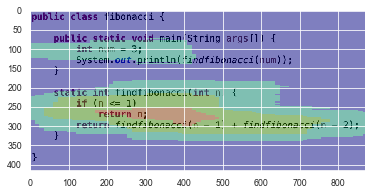

In [45]:
horizontal_data = np.zeros(data.shape)

for height_idx in range(len(data)):
    for val in range(0, width, chunk_width):
        max_val = data[height_idx, val:(val+chunk_width)].max()
        horizontal_data[height_idx, val:(val+chunk_width)] = max_val

tmp = horizontal_data.flatten().tolist()
im = image_array[0].copy()
heathelpers.draw_heat(im, tmp)

imgplot0 = plt.imshow(im)

In [41]:
line_data = np.zeros(data.shape)
for _idx, row in config_array[0].iterrows():
    low = row["start"]
    high = row["stop"]
    for val in range(0, width, chunk_width):
        max_val = data[low:high, val:(val+chunk_width)].max()
        line_data[low:high, val:(val+chunk_width)] = max_val

tmp = line_data.flatten().tolist()
im = image_array[0].copy()
heathelpers.draw_heat(im, tmp)

imgplot0 = plt.imshow(im)

AttributeError: 'list' object has no attribute 'shape'

In [42]:
stim_str = []
for lst in visual_stimulus_code_flow_matrix[0]:
    tmp_lst = []
    for val in lst:
        tmp_lst.append(str(val))
    stim_str.append(tmp_lst)

In [43]:
def get_tokens_from(token_list, idx, max_traceback):
    result = []
    idx = min(idx, len(token_list)-1)
    
    for token_idx in reversed(range(max(0, idx-max_traceback), idx+1)):
        result.append(token_list[token_idx])
    return result

def get_token_tuple(token_matrix, idx, traceback_array):
    result = []
    for iter_idx in range(len(token_matrix)):
        value = get_tokens_from(token_matrix[iter_idx], idx, traceback_array[iter_idx])
        result.append(value)
    
    result = [item for sublist in result for item in sublist]
    result = list(set(result))
    return result


In [46]:
data = stim_str
lengths = [len(val) for val in data]
max_val = max(lengths)
lengths = [max(lengths)-x for x in lengths]

In [59]:
import itertools

tups = []
for i in range(4):
    print(i, flush=True, end=' ')
    tups.append(get_token_tuple(data, i, lengths))

tups = list(itertools.product(*tups))
len(tups)

0 1 2 3 

1008

In [63]:
max_sim_value = -1
max_sim_index = -1

for idx, matching_sequence in enumerate(tups):
    value = 0
    for word in data:
        value = value + difflib.SequenceMatcher(None, matching_sequence, word).real_quick_ratio()
        
    if value > max_sim_value:
        max_sim_value = value
        max_sim_index = idx

#print(tups[max_sim_index])
for word in data:
    print(str(word))

['1', '3', '4', '5', '5', '8', '9', '9', '11', '11', '9', '11', '11', '11', '11', '9', '11', '3', '4', '5']
['2', '1', '3', '4', '4', '4', '5', '4', '6', '6', '5', '4', '7', '9', '8', '4', '5', '9', '9', '12', '12', '12', '12', '9', '5', '4', '2', '10', '11', '11', '6', '4', '11', '11', '12', '11', '9', '11', '12', '11', '9', '10', '5', '5', '5', '5']
['4', '5', '4', '5', '8', '9', '4', '11', '11', '10', '11']
['4', '6', '10', '11', '10', '11']
['1', '1', '3', '3', '4', '5', '8', '8', '9', '10', '11', '11', '11', '11', '10', '9', '10', '4', '10', '12', '11', '11', '11', '9', '10', '11', '11', '11', '9', '10', '11', '10', '11', '11', '11']
['1', '1', '3', '3', '5', '5', '8', '10', '11', '11', '11', '12', '10', '5', '1', '3', '4', '5', '5', '5', '10', '12', '11', '11', '12', '9', '10', '11', '8', '11', '12', '11']
['2', '2', '2', '2', '3', '4', '4', '4', '5', '4', '3', '5', '4', '4', '6', '6', '5', '8', '9', '4', '8', '5', '5', '9', '9', '11', '12', '11', '11', '11', '10', '10', '11', '1